In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience but this could be switched to SI if needed
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams

## part b

In [ ]:
def P_from_rho(rho):
    x = x_from_rho(rho)
    return P_from_x(x)
def P_from_x(x):
    lamb = hbar/(me*c)
    return me*c**2/(lamb**3)*phi_from_x(x)
def phi_from_x(x):
    return (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*((2*x**2)/3-1)+np.log(x+np.sqrt(1+x**2)))
def x_from_rho(rho):
    lamb = hbar/(me*c)
    return lamb*(3*np.pi**2*rho/(m_u*mu_e))**(1/3)

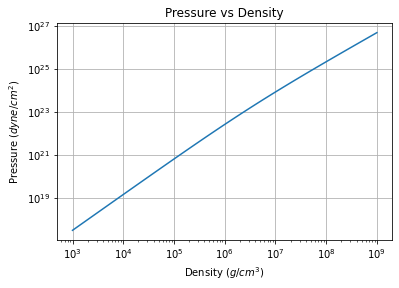

In [12]:
rho = np.logspace(3,9,100)
P = P_from_rho(rho)
plt.plot(rho, P)
plt.title("Pressure vs Density")
plt.xlabel("Density ($g/cm^3$)")
plt.ylabel("Pressure ($dyne/cm^2$)")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

## part c

In [275]:
def newton_raphson(func, dfunc, x0, tol=1e-10, max_iter=100000):
    x = x0
    xHist = np.array([x0])
    fxHist = np.array([0])
    dfxHist = np.array([0])
    for i in range(max_iter):
        fx = func(x)
        dfx = dfunc(x)
        if dfx == 0:
            raise ValueError("Derivative is zero. No solution found.")
        x_new = x - fx/dfx
        xHist = np.append(xHist, x_new)
        fxHist = np.append(fxHist, fx)
        dfxHist = np.append(dfxHist, dfx)
        
        if abs(x_new - x) < tol:
            return x_new
        
        if np.isnan(x_new) or np.isinf(x_new):
            print("NaN or Inf detected. No solution found. Returning last estimate.")
            
            return x
        if x_new <= 0:
            print("Non-physical negative or zero value encountered. No solution found. Returning last estimate.")
            
            return x
        else:
            x = x_new

    print("Maximum iterations reached. No solution found. Returning last estimate.")
    return x

In [273]:
def rho_from_P(Pin, tol=1e-8, relativistic=False):
    #in the following cases, r represents rho
    func = lambda r:P_from_rho(r) -Pin
    
    #df/dr = dP/dphi*dphi/dx*dx/dr
    dxdr = lambda r: (hbar/(me*c))*((3*np.pi**2/(m_u*mu_e))**(1/3))*1/(3*r**(2/3))
    dpdphi = me*c**2/(hbar/(me*c))**3
    # I did the derivative by hand originally, but I messed it up I think by forgetting a sign somewhere, this is from derivative calculator
    dphidx = lambda x: (1/(3*np.pi**2)) * x**4 / np.sqrt(1+x**2)
    dfunc = lambda r: dpdphi*dphidx(x_from_rho(r))*dxdr(r)
    
    if relativistic:
        k = 3**(1/3)*np.pi**(2/3)*hbar*c/(4*mu_e**(4/3)*m_u**(4/3))
        r0 = (Pin/k)**(3/4)
    else:
        k = 3**(2/3)*np.pi**(4/3)*hbar**2/(5*mu_e**(5/3)*m_u**(5/3)*me)
        r0 = (Pin/k)**(3/5)
    r_sol = newton_raphson(func, dfunc, r0, tol=tol)
    return r_sol

Maximum iterations reached. No solution found. Returning last estimate.


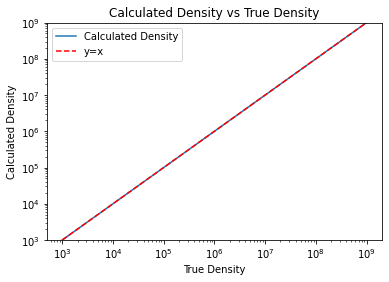

In [274]:
#testing rho_from_P
true_rho = np.logspace(3,9,100)
true_P = [P_from_rho(r) for r in true_rho]
calc_rho = [rho_from_P(p) for p in true_P]
plt.plot(true_rho, calc_rho,label='Calculated Density')
plt.plot(np.logspace(3,9,10), np.logspace(3,9,10), linestyle='--', color='red', label='y=x')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e3,1e9)
plt.title("Calculated Density vs True Density")
plt.xlabel("True Density")
plt.ylabel("Calculated Density")
plt.legend()
plt.show()


## part d

In [261]:
def derivative(r, m, P):
    #returns dm/dr and dP/dr according to equations 1.92 and 1.94
    
    rho = rho_from_P(P)
    dmdr = 4*np.pi*(r**2)*rho
    dPdr = -G*m*rho/r**2
    return np.stack((dmdr, dPdr))

## part e

In [262]:
def rk4_step(r, m, P, h=0.5):
    #performs a single RK4 step
    k1 = derivative(r, m, P)
    k2 = derivative(r + h/2, m + h/2*k1[0], P + h/2*k1[1])
    k3 = derivative(r + h/2, m + h/2*k2[0], P + h/2*k2[1])
    k4 = derivative(r + h, m + h*k3[0], P + h*k3[1])

    dm = (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) * h / 6
    dP = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) * h / 6

    m_new = m + dm
    P_new = P + dP
    
    return m_new, P_new

## part f

In [263]:
def integrate_star(r0,m0,P0, dr=0.05, maxIterations=1000):
    i=0
    r = np.array([r0])
    m = np.array([m0])
    P = np.array([P0])
    P_central = P0
    while i < maxIterations:
        # Perform a single RK4 step
        m_new, P_new = rk4_step(r[-1], m[-1], P[-1], h=dr)
        # Update the values for the next iteration
        r = np.append(r, r[-1] + dr)
        m = np.append(m, m_new)
        P = np.append(P, P_new)
        # Check for stopping condition (the pressure is 10^-10 of the central pressure)
        if P[-1]/P_central < 1e-10:
            return r, m, P
        i += 1
    return r, m, P

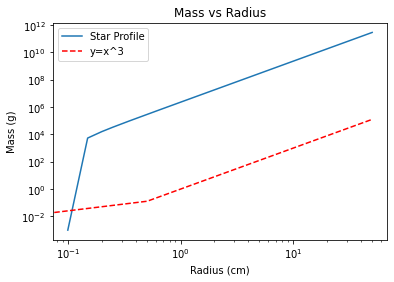

In [266]:
#test the integrate_star function
r=[]
m=[]
P=[]
r.append(0.1)
m.append(0.1**3)
P.append(1e22)

r,m,P = integrate_star(r,m,P)
plt.plot(r,m,label="Star Profile")
plt.plot(np.linspace(0,np.max(r),100), np.linspace(0,np.max(r),100)**3, linestyle='--', color='red', label='y=x^3')
plt.xlabel("Radius (cm)")
plt.ylabel("Mass (g)")
plt.title("Mass vs Radius")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

## part g

Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last estimate.
Maximum iterations reached. No solution found. Returning last es

KeyboardInterrupt: 

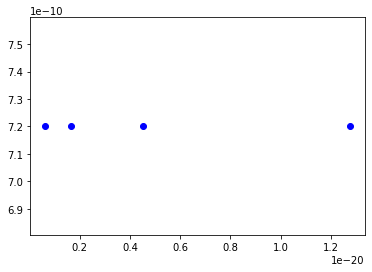

In [276]:
for P0 in np.logspace(23,35,20):
    r,m,P = integrate_star([0.1],[0.1**3],[P0])
    plt.scatter(m[-1]/Msun, r[-1]/Rsun, color='blue')
parsonsM = [0.4756, 0.4164, 0.6579, 0.4817, 0.3780, 0.3160, 0.5618, 0.5354, 0.7816, 0.4475, 0.5340, 0.4406, 0.4656, 0.5290, 0.5964, 0.5140, 0.5338, 0.4146, 0.6050, 0.4150, 0.4393, 0.6098, 0.3916, 0.3977, 0.8400, 0.4356]
parsonsR = [0.01749, 0.02521, 0.01221, 0.01578, 0.02224, 0.02066, 0.01700, 0.02080, 0.01068, 0.01568,0.01398, 0.01747, 0.01840, 0.01310, 0.01594, 0.02470, 0.01401, 0.01768, 0.01278, 0.01590, 0.01680, 0.01207,0.01800, 0.01975, 0.01070, 0.01570]
plt.scatter(parsonsM,parsonsR,label='Parsons et al.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass (M_sun)")
plt.ylabel("Radius (R_sun)")
plt.title("Mass-Radius Relation for White Dwarfs")
plt.grid()
#try to investigate why for hiigh masses it's not converging. do i just need to relax my tolerance?? or is it something else? (include a check for diverging)

In [ ]:
r=[]
m=[]
P=[]
r.append(0.1)
m.append(1)
P.append(1e6)